<div style='background-color: #fff3cd; border: 1px solid #ffeaa7; border-radius: 4px; padding: 15px; margin: 10px 0; border-left: 4px solid #f39c12;'>
<h3 style='color: #856404; margin-top: 0;'>⚠️ EXECUTION WARNING</h3>
<p style='color: #856404; margin-bottom: 0;'><strong>This notebook may not execute properly in the current environment.</strong></p>
<p style='color: #856404; margin-bottom: 0;'>Some cells may have failed during automated testing. Please review the notebook content and test manually before use.</p>
<p style='color: #856404; margin-bottom: 0; font-size: 0.9em;'><em>Generated during CI/CD pipeline - some outputs may be incomplete or missing.</em></p>
</div>


<a id="top"></a>

![STScI Logo](../../../_static/stsci_header.png)

# Analyzing WFC3/UVIS G280 Exoplanet Transit Observations

<hr>

## Learning Goals
This notebook demonstrates reduction and analysis of exoplanet transit observations of the 
hot Jupiter HAT-P-41b taken with the WFC3/UVIS G280 grism. By the end of this tutorial, you will be able to do the following for G280 time-series transit observations: 

- Perform a background subtraction.
- Remove cosmic rays spatially and temporally.
- Perform trace fitting to extract the 1D time-series of stellar spectra.
- Produce light curves for transit fitting.

## Table of Contents

[Introduction](#intro) <br>
[1. Imports](#import) <br>
[2. Downloading Grism Observations from MAST](#data_download) <br>
- [2.1 Direct Image](#direct_image) <br>
- [2.2 Example G280 Spectrum](#spectrum) <br>
- [2.3 Examining the Time-Series](#time_series) <br>

[3. Background Subtraction](#bkgd_sub) <br>
[4. Cosmic Ray Correction](#cr_corr) <br>
[5. Embedding Subarrays](#embed_sub) <br>
[6. Spectral Trace Fitting](#trace_fitting) <br> 
[7. G280 Spectral Extraction](#extraction) <br> 
[8. Extracting 1D Time-Series Stellar Spectra](#spectra) <br> 
[9. Generating Transit Light Curves](#lc) <br> 
[10. Conclusions](#summary) <br> 

[Additional Resources](#add) <br>
[About this Notebook](#about) <br>
[Citations](#cite) <br>

## Introduction
<a id="intro"></a>

Time-series observations of transiting exoplanets can allow us to measure their atmospheric compositions. Hubble has paved the way for such observations, where STIS (G430L, G750L) and WFC3 (G102, G141) served as the workhorse instruments for transit spectroscopy over the past two decades. Recently, however, WFC3's G280 grism  has become popular among the exoplanet community thanks to recent studies demonstrating its usefulness for transit observations (e.g., [Wakeford et al. 2020](https://arxiv.org/abs/2003.00536), [Lothringer et al. 2022](https://arxiv.org/abs/2204.03639), [Boehm et al. 2024](https://arxiv.org/abs/2410.17368)). In particular, G280's blue-optical wavelength range (0.2-0.8 $\mu$m) can yield critical information about the cloud and haze properties in exoplanets' atmospheres. 

## 1. Imports
<a id="import"></a>

This notebook assumes you have installed the required libraries as described [here](https://github.com/spacetelescope/hst_notebooks/blob/main/notebooks/WFC3/uvis_g280_transit/requirements.txt).

- `glob` for finding directories & files
- `os` for operating system operations
- `shutil` for file operations
- `tqdm` for loading bars
    
- `numpy` for handling array functions
- `matplotlib` for plotting data
  
- `astropy.io fits` for accessing FITS files
- `astropy.stats sigma_clipped_stats` for outlier removal 
- `astroquery.mast Observations` for downloading data from MAST
- `photutils.detection DAOStarFinder` for source detection in an image

We also import a custom module `g280_transit_tools.py` for G280-specific reduction & analysis tools.

In [1]:
import glob
import os
import shutil
import tqdm

import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astroquery.mast import Observations
from photutils.detection import DAOStarFinder

import g280_transit_tools

%matplotlib inline

## 2. Downloading Grism Observations from MAST
<a id="data_download"></a>

First, we query the observations necessary to complete the tutorial from the [Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/). Using the G280 grism, [GO 15288](https://www.stsci.edu/hst-program-info/program/?program=15288) observed transits of the giant exoplanet HAT-P-41b, which was the first exoplanet planet transit data set ever taken with G280. The results of this analysis are published in Wakeford et al. (2020). To query only the first visit of the proposal and reject bias frames, we use a wildcard for `obs_id` and specify `target_name`.

In [2]:
transit_obs = Observations.query_criteria(obs_id='idps01*', target_name='HAT-P-41B')

Next, we retrieve a filtered product list of our observations. For our analysis, we use the `_flt.fits` (i.e. calibrated, flat-fielded exposure) files produced using the `calwf3` pipeline.

In [3]:
transit_prods = Observations.get_product_list(transit_obs)
transit_prods_filtered = Observations.filter_products(transit_prods, extension=["_flt.fits"], type='S')

Now, we download the `_flt.fits` files from MAST.

In [4]:
Observations.download_products(transit_prods_filtered, mrp_only=False, cache=False)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/idps01plq/idps01plq_flt.fits,COMPLETE,None,None
./mastDownload/HST/idps01piq/idps01piq_flt.fits,COMPLETE,None,None
./mastDownload/HST/idps01p9q/idps01p9q_flt.fits,COMPLETE,None,None
./mastDownload/HST/idps01pcq/idps01pcq_flt.fits,COMPLETE,None,None
./mastDownload/HST/idps01p0q/idps01p0q_flt.fits,COMPLETE,None,None
./mastDownload/HST/idps01pmq/idps01pmq_flt.fits,COMPLETE,None,None
./mastDownload/HST/idps01p8q/idps01p8q_flt.fits,COMPLETE,None,None
./mastDownload/HST/idps01pfq/idps01pfq_flt.fits,COMPLETE,None,None
./mastDownload/HST/idps01peq/idps01peq_flt.fits,COMPLETE,None,None


The `_flt.fits` files for HAT-P-41b are now in our current working directory under `mastDownload`. We organize this data into separate directories for the `_flt.fits` and remove the `mastDownload` directory. 

We define all the subdirectories for MAST, data, direct image, and `_flt.fits` (calibrated, clean, and full frame).

In [5]:
cwd = os.getcwd()
download_dir = os.path.join(cwd, 'mastDownload/HST')
data_dir = os.path.join(cwd, 'data')
image_dir = os.path.join(cwd, 'direct_image')
flt_dir = os.path.join(data_dir, 'flt')
flt_clean_dir = os.path.join(data_dir, 'flt_clean')
flt_full_dir = os.path.join(data_dir, 'flt_full')

We create each subdirectory.

In [6]:
for sub_dir in [data_dir, image_dir, flt_dir, flt_clean_dir, flt_full_dir]:
    os.makedirs(sub_dir, exist_ok=True)

We move the files to the appropriate subdirectories.

In [7]:
# Retrieve paths in MAST
paths_old = sorted(glob.glob(f'{download_dir}/*/*'))

# Loop through paths
for path_old in paths_old:
    basename_old = os.path.basename(path_old)
    # Put direct image in appropriate subdirectory
    if 'idps01oqq' in basename_old:
        sub_dir = image_dir
    # Put grism images in appropriate subdirectory
    else:
        sub_dir = flt_dir
    path_new = f'{sub_dir}/{basename_old}'
    os.rename(path_old, path_new)

We delete the MAST subdirectory.

In [8]:
if os.path.isdir(download_dir):
    shutil.rmtree('mastDownload/')

Now that we have downloaded and organized the relevant files for our time-series analysis, we can analyze them.  

### 2.1 Direct Image
<a id="direct_image"></a> 

We retrieve the direct image data of the target, which was taken with the F300X filter. It is common practice for time-series transit observations to take a direct image of the target before taking spectroscopic data.

In [9]:
path_direct_image = f'{image_dir}/idps01oqq_flt.fits'
file_direct_image = os.path.basename(path_direct_image)
direct_image = fits.getdata(path_direct_image)

Now, we plot the direct image using 1 and 99 percentile min and max values, respectively.

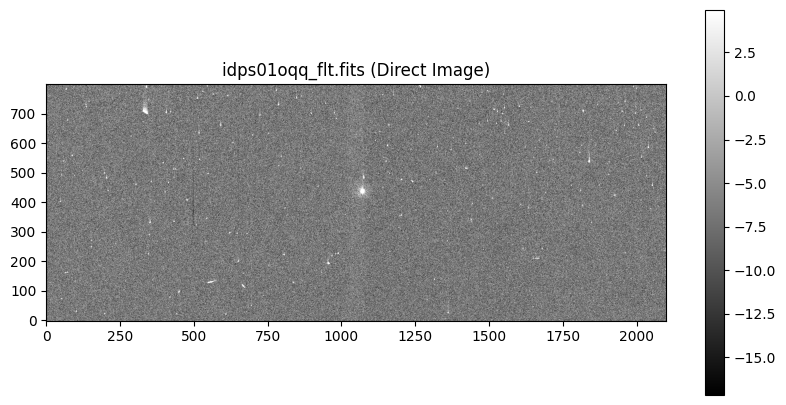

In [10]:
vmin, vmax = np.percentile(direct_image, (1, 99))
plt.figure(figsize=[10, 5])
plt.title(f'{file_direct_image} (Direct Image)')
plt.imshow(direct_image, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.colorbar()

By eye, we can see that our target is the bright source in the center of this image, but let's find its location more precisely. First, we find the 3-sigma clipped mean, median, and standard deviation 

In [11]:
mean, median, std = sigma_clipped_stats(direct_image, sigma=3.0)

Next, we set our [DAOStarFinder algorithm](https://ui.adsabs.harvard.edu/abs/1987PASP...99..191S/abstract) to a full width half maximum of 5 and a threshold 1075 times the standard deviation.

In [12]:
find_source = DAOStarFinder(fwhm=5, threshold=1075*std)

Then, we find our sources from the global background (i.e. median) subtracted image.

In [13]:
sources = find_source(direct_image - median)

Finally, we format our columns and return the found sources.

In [14]:
for column in sources.colnames:
    sources[column].info.format = '%.8g'   
sources

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,peak,flux,mag,daofind_mag
int64,float64,float64,float64,float32,float64,int64,float32,float32,float32,float64
1,1069.8841,437.85493,0.97561314,-0.10247992,0.060946854,49,8806.0215,58814.789,-11.923716,-0.71761844


Our target HAT-P-41b is located around (x,y) = (1070, 438). However, this is in the subarray frame. Therefore, we convert our source coordinates from the subarray frame to the full frame, which is needed later in the analysis. To do this, we use the `LTV` keywords from the `SCI` extension.

In [15]:
# Extract subarray offsets
x_offset = int(-fits.getval(path_direct_image, 'ltv1', 1))
y_offset = int(-fits.getval(path_direct_image, 'ltv2', 1))

# Extract source coordinates from direct image
source_x_direct = sources['xcentroid'].data[0]
source_y_direct = sources['ycentroid'].data[0]

# Convert coordinates from subarray to full frame
source_x = source_x_direct + x_offset
source_y = source_y_direct + y_offset

print(f'Source Location: (x, y) = {source_x:.4f}, {source_y:.4f}')

Source Location: (x, y) = 2040.8841, 1063.8549


Our source location of HAT-P-41b is within a few hundreths of a pixel to Section 3.1 of [Wakeford et al. (2020)](https://arxiv.org/pdf/2003.00536) (2040.8756, 1063.8825).

### 2.2 Example G280 Spectrum 
<a id="spectrum"></a> 
We retrieve the data from one of the spectra in the time-series.

In [16]:
# Retrieve all paths
paths_flt = sorted(glob.glob(f'{flt_dir}/*'))

# Retrieve data from first path
path_grism_image = paths_flt[0]
file_grism_image = os.path.basename(path_grism_image)
grism_image = fits.getdata(path_grism_image)

Now, we plot a grism image using 1 and 99 percentile min and max values, respectively.

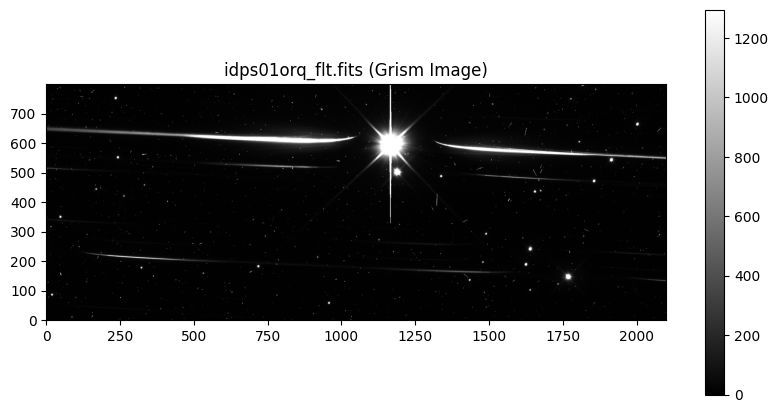

In [17]:
vmin, vmax = np.percentile(grism_image, (1, 99))
plt.figure(figsize=[10, 5])
plt.title(f'{file_grism_image} (Grism Image)')
plt.imshow(grism_image, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
plt.colorbar()

G280 spectra have curved spectral traces and multiple overlapping spectral orders. The zeroth order is shown in the center of the image, and is saturated with large diffraction spikes. The spectral traces to the left of the zeroth order are the positive orders, and the traces to the right of the zeroth order are the negative orders. The brightest orders that we can see here are the +1 and -1 orders. 

### 2.3 Examining the Time-Series
<a id="time_series"></a> 

We extract the data from each spectrum, and print the shape.

In [18]:
time_series_grism = np.array([fits.getdata(path) for path in paths_flt], dtype=np.float64)
n_spectra, y_length, x_length = time_series_grism.shape
print(f'Spectra time-series shape {time_series_grism.shape}')

Spectra time-series shape (54, 800, 2100)


Next, we plot a standard deviation stack of the grism images to better understand outliers in the data.

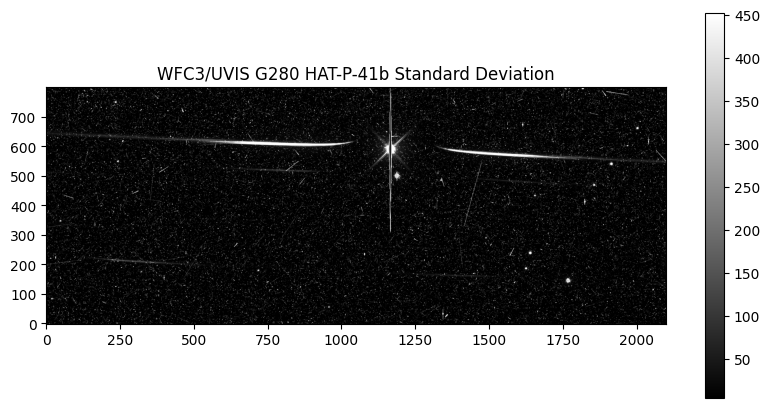

In [19]:
# Standard deviation stack grisms
grism_std = np.std(time_series_grism, axis=0)

# Plot
vmin_std, vmax_std = np.percentile(grism_std, (1, 99))
plt.figure(figsize=[10, 5])
plt.title('WFC3/UVIS G280 HAT-P-41b Standard Deviation')
plt.imshow(grism_std, vmin=vmin_std, vmax=vmax_std, origin='lower', cmap='gray')
plt.colorbar()

Several hot/bad pixels are present in these images as seen above. The first step in the data reduction process is to clean each exposure in the time-series data and remove these bad pixels, which can affect the precision of our extracted stellar spectra and transit light curves. 

## 3. Background Subtraction
<a id="bkgd_sub"></a> 

First, we perform a background subtraction for all of the spectra in the time-series. There are a few ways to do this, but here we will use the publicly available [G280 sky frames](https://www.stsci.edu/hst/instrumentation/wfc3/documentation/grism-resources/uvis-grism-sky-images), which should be downloaded before execution. These sky frames were generated by stacking all public on-orbit science exposures on MAST (as of July 2023) and aggressively masking sources using a modified segmentation map ([Pagul et al. 2023](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2023/WFC3-ISR-2023-06.pdf)). Since our grisms were observed on UVIS2, we download that sky frame.

In [20]:
!curl -O https://www.stsci.edu/~WFC3/grism-resources/uvis-grism-sky-images/G280sky_chip2_flt_v1.0.fits

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

100 32.0M  100 32.0M    0     0   157M      0 --:--:-- --:--:-- --:--:--  157M


Then, we load the UVIS2 G280 sky frame.

In [21]:
g280_sky_full = fits.getdata('G280sky_chip2_flt_v1.0.fits')

We plot the sky with a box around the subarray.

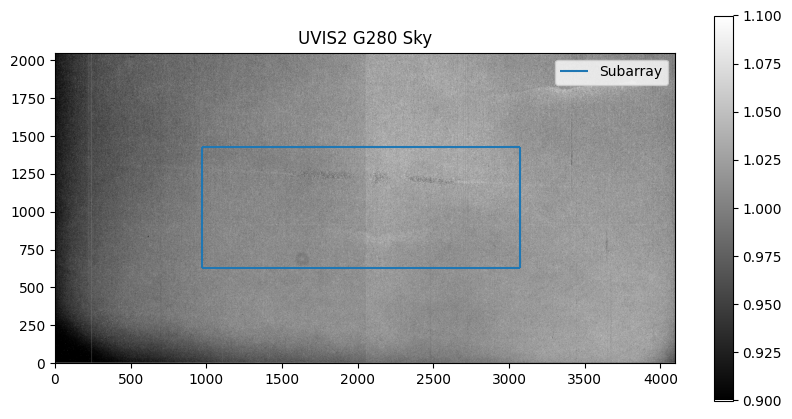

In [22]:
# Plot sky
plt.figure(figsize=[10, 5])
plt.title('UVIS2 G280 Sky')
plt.imshow(g280_sky_full, vmin=0.9, vmax=1.1, origin='lower', cmap='gray')
plt.colorbar()

# Plot box around subarray
plt.vlines(x_offset, y_offset, y_offset + y_length, label='Subarray')
plt.vlines(x_offset + x_length, y_offset, y_offset + y_length)
plt.hlines(y_offset, x_offset, x_offset + x_length)
plt.hlines(y_offset + y_length, x_offset, x_offset + x_length)
plt.legend()

Next, we extract the subarray pixels from the sky.

In [23]:
g280_sky = g280_sky_full[y_offset:y_offset+y_length, x_offset:x_offset+x_length]

Then, we scale each sky by each exposure's median.

In [24]:
time_series_grism_median = np.median(time_series_grism, axis=(1, 2)).reshape(-1, 1, 1) * np.ones_like(time_series_grism)
time_series_g280_sky = g280_sky * time_series_grism_median

Now, we apply background subtraction to each science frame.

In [25]:
time_series_bkg_sub = time_series_grism - time_series_g280_sky

## 4. Cosmic Ray Correction
<a id="cr_corr_sub"></a> 

Now, we remove cosmic rays, which can not only hit the detector throughout the course of the hours-long time-series observations, but may also be more frequent in G280 data due to its wide wavelength coverage. It is important to correct for cosmic rays within an exposure (spatially) and also across exposures in the time-series (temporally).

First, we apply the temporal and spatial cosmic ray correction routines using `g280_transit_tools.remove_cosmic_rays_time` and `g280_transit_tools.remove_cosmic_rays_space`. These functions return the corrected data, and the masks for corrected pixels.

In [26]:
# Temporal correction
time_series_cr_time, mask_outliers_time = g280_transit_tools.remove_cosmic_rays_time(time_series_bkg_sub, n_sigma=4, n_iter=4)

# Spatial correction
time_series_cr_corr, mask_outliers_space = g280_transit_tools.remove_cosmic_rays_space(time_series_cr_time, n_sigma=3, size=3)

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:07,  2.53s/it]

 50%|█████     | 2/4 [00:05<00:05,  2.51s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.42s/it]

100%|██████████| 4/4 [00:09<00:00,  2.38s/it]

100%|██████████| 4/4 [00:09<00:00,  2.41s/it]

  0%|          | 0/54 [00:00<?, ?it/s]

  2%|▏         | 1/54 [00:00<00:12,  4.18it/s]

  4%|▎         | 2/54 [00:00<00:12,  4.20it/s]

  6%|▌         | 3/54 [00:00<00:12,  4.20it/s]

  7%|▋         | 4/54 [00:00<00:11,  4.21it/s]

  9%|▉         | 5/54 [00:01<00:11,  4.22it/s]

 11%|█         | 6/54 [00:01<00:11,  4.23it/s]

 13%|█▎        | 7/54 [00:01<00:11,  4.24it/s]

 15%|█▍        | 8/54 [00:01<00:10,  4.25it/s]

 17%|█▋        | 9/54 [00:02<00:10,  4.24it/s]

 19%|█▊        | 10/54 [00:02<00:10,  4.25it/s]

 20%|██        | 11/54 [00:02<00:10,  4.25it/s]

 22%|██▏       | 12/54 [00:02<00:09,  4.24it/s]

 24%|██▍       | 13/54 [00:03<00:09,  4.17it/s]

 26%|██▌       | 14/54 [00:03<00:09,  4.19it/s]

 28%|██▊       | 15/54 [00:03<00:09,  4.21it/s]

 30%|██▉       | 16/54 [00:03<00:08,  4.23it/s]

 31%|███▏      | 17/54 [00:04<00:08,  4.24it/s]

 33%|███▎      | 18/54 [00:04<00:08,  4.25it/s]

 35%|███▌      | 19/54 [00:04<00:08,  4.25it/s]

 37%|███▋      | 20/54 [00:04<00:07,  4.25it/s]

 39%|███▉      | 21/54 [00:04<00:07,  4.25it/s]

 41%|████      | 22/54 [00:05<00:07,  4.24it/s]

 43%|████▎     | 23/54 [00:05<00:07,  4.19it/s]

 44%|████▍     | 24/54 [00:05<00:07,  4.20it/s]

 46%|████▋     | 25/54 [00:05<00:06,  4.21it/s]

 48%|████▊     | 26/54 [00:06<00:06,  4.18it/s]

 50%|█████     | 27/54 [00:06<00:06,  4.19it/s]

 52%|█████▏    | 28/54 [00:06<00:06,  4.20it/s]

 54%|█████▎    | 29/54 [00:06<00:05,  4.21it/s]

 56%|█████▌    | 30/54 [00:07<00:05,  4.21it/s]

 57%|█████▋    | 31/54 [00:07<00:05,  4.22it/s]

 59%|█████▉    | 32/54 [00:07<00:05,  4.23it/s]

 61%|██████    | 33/54 [00:07<00:04,  4.22it/s]

 63%|██████▎   | 34/54 [00:08<00:04,  4.23it/s]

 65%|██████▍   | 35/54 [00:08<00:04,  4.24it/s]

 67%|██████▋   | 36/54 [00:08<00:04,  4.24it/s]

 69%|██████▊   | 37/54 [00:08<00:04,  4.24it/s]

 70%|███████   | 38/54 [00:08<00:03,  4.25it/s]

 72%|███████▏  | 39/54 [00:09<00:03,  4.24it/s]

 74%|███████▍  | 40/54 [00:09<00:03,  4.24it/s]

 76%|███████▌  | 41/54 [00:09<00:03,  4.25it/s]

 78%|███████▊  | 42/54 [00:09<00:02,  4.23it/s]

 80%|███████▉  | 43/54 [00:10<00:02,  4.23it/s]

 81%|████████▏ | 44/54 [00:10<00:02,  4.24it/s]

 83%|████████▎ | 45/54 [00:10<00:02,  4.23it/s]

 85%|████████▌ | 46/54 [00:10<00:01,  4.23it/s]

 87%|████████▋ | 47/54 [00:11<00:01,  4.24it/s]

 89%|████████▉ | 48/54 [00:11<00:01,  4.23it/s]

 91%|█████████ | 49/54 [00:11<00:01,  4.23it/s]

 93%|█████████▎| 50/54 [00:11<00:00,  4.24it/s]

 94%|█████████▍| 51/54 [00:12<00:00,  4.24it/s]

 96%|█████████▋| 52/54 [00:12<00:00,  4.25it/s]

 98%|█████████▊| 53/54 [00:12<00:00,  4.25it/s]

100%|██████████| 54/54 [00:12<00:00,  4.25it/s]

100%|██████████| 54/54 [00:12<00:00,  4.23it/s]

We compare the raw 2D spectral image to the spectrum corrected for outliers.

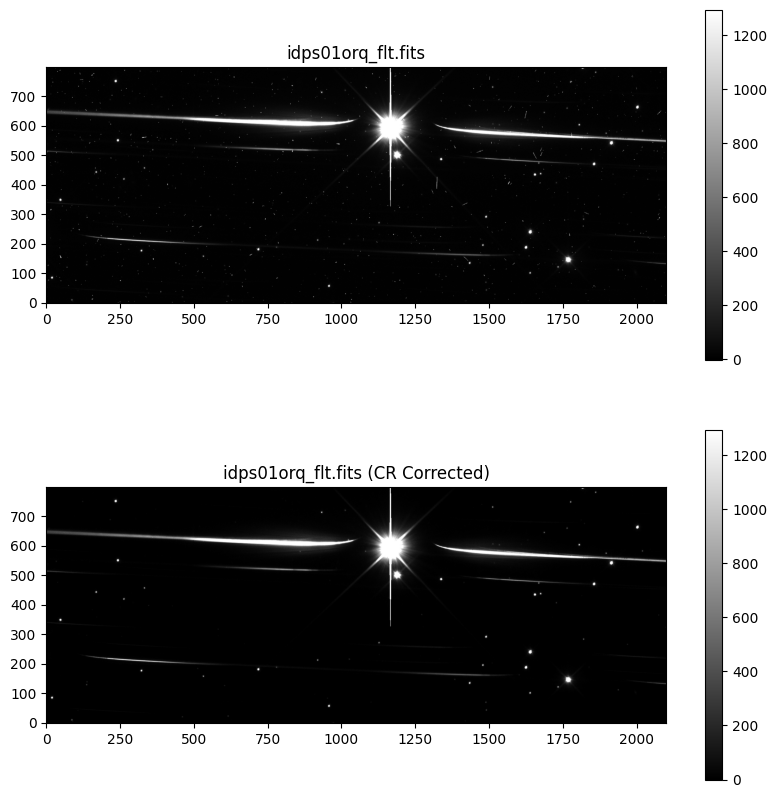

In [27]:
fig, axs = plt.subplots(2, 1, figsize=[10, 10])

# Plot grism image
axs[0].set_title(file_grism_image)
axs0 = axs[0].imshow(grism_image, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
cbar = fig.colorbar(axs0, ax=axs[0])

# Plot clean grism image
axs[1].set_title(f'{file_grism_image} (CR Corrected)')
axs1 = axs[1].imshow(time_series_cr_corr[0], vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
cbar = fig.colorbar(axs1, ax=axs[1])

Our routine sufficiently removed the outliers. All we have left are background stars. Now, we save the cosmic ray corrected data as `_c_flt.fits` files.

In [28]:
# Loop through paths
for i, path in tqdm.tqdm(enumerate(paths_flt), total=len(paths_flt)):

    # Make a copy of each file
    file_c = os.path.basename(path.replace('flt.fits', 'c_flt.fits'))
    path_c = f'{flt_clean_dir}/{file_c}'
    shutil.copyfile(path, path_c)

    # Update the copy
    with fits.open(path_c, mode='update') as hdu:
        hdu['SCI', 1].data = time_series_cr_corr[i]

  0%|          | 0/54 [00:00<?, ?it/s]

  4%|▎         | 2/54 [00:00<00:02, 18.16it/s]

  7%|▋         | 4/54 [00:00<00:02, 18.73it/s]

 11%|█         | 6/54 [00:00<00:02, 18.98it/s]

 15%|█▍        | 8/54 [00:00<00:02, 18.91it/s]

 19%|█▊        | 10/54 [00:00<00:02, 18.97it/s]

 22%|██▏       | 12/54 [00:00<00:02, 19.07it/s]

 26%|██▌       | 14/54 [00:00<00:02, 19.00it/s]

 30%|██▉       | 16/54 [00:00<00:01, 19.02it/s]

 33%|███▎      | 18/54 [00:00<00:01, 19.09it/s]

 37%|███▋      | 20/54 [00:01<00:01, 19.22it/s]

 41%|████      | 22/54 [00:01<00:01, 19.21it/s]

 44%|████▍     | 24/54 [00:01<00:01, 19.32it/s]

 48%|████▊     | 26/54 [00:01<00:01, 19.07it/s]

 52%|█████▏    | 28/54 [00:01<00:01, 19.28it/s]

 56%|█████▌    | 30/54 [00:01<00:01, 19.34it/s]

 59%|█████▉    | 32/54 [00:01<00:01, 19.24it/s]

 63%|██████▎   | 34/54 [00:01<00:01, 19.15it/s]

 67%|██████▋   | 36/54 [00:01<00:00, 19.14it/s]

 70%|███████   | 38/54 [00:01<00:00, 19.13it/s]

 74%|███████▍  | 40/54 [00:02<00:00, 19.12it/s]

 78%|███████▊  | 42/54 [00:02<00:00, 13.16it/s]

 81%|████████▏ | 44/54 [00:02<00:00, 14.51it/s]

 85%|████████▌ | 46/54 [00:02<00:00, 11.12it/s]

 89%|████████▉ | 48/54 [00:02<00:00, 12.68it/s]

 93%|█████████▎| 50/54 [00:02<00:00, 13.99it/s]

 96%|█████████▋| 52/54 [00:03<00:00, 15.16it/s]

100%|██████████| 54/54 [00:03<00:00, 10.49it/s]

100%|██████████| 54/54 [00:03<00:00, 15.94it/s]

## 5. Embedding Subarrays
<a id="embed_sub"></a>  

The G280 spectra are taken on UVIS2, but we need to embed this subarray into the full frame image in order to proceed with the spectral extraction. For this step, we use `g280_transit_tools.embedsub_uvis`, which is a derivative of [`wfc3tools.embedsub`](https://github.com/spacetelescope/wfc3tools/blob/main/wfc3tools/embedsub.py). The former function uses header keywords from the `_flt.fits` file (i.e. `NAXIS`, `LTV`), while the latter function requires keywords from the `_spt.files`.

In [29]:
# Retrieve clean flt paths
paths_c_flt = sorted(glob.glob(f'{flt_clean_dir}/*'))

# Loop through cleaned paths and embed
for path_c in tqdm.tqdm(paths_c_flt, total=len(paths_c_flt)):
    path_c_f = g280_transit_tools.embedsub_uvis(path_c, flt_full_dir)

  0%|          | 0/54 [00:00<?, ?it/s]

  2%|▏         | 1/54 [00:00<00:23,  2.23it/s]

  4%|▎         | 2/54 [00:00<00:22,  2.36it/s]

  6%|▌         | 3/54 [00:01<00:17,  2.88it/s]

  7%|▋         | 4/54 [00:01<00:15,  3.23it/s]

  9%|▉         | 5/54 [00:01<00:19,  2.55it/s]

 11%|█         | 6/54 [00:02<00:15,  3.20it/s]

 13%|█▎        | 7/54 [00:02<00:12,  3.85it/s]

 15%|█▍        | 8/54 [00:02<00:10,  4.44it/s]

 17%|█▋        | 9/54 [00:02<00:08,  5.00it/s]

 19%|█▊        | 10/54 [00:02<00:08,  5.36it/s]

 20%|██        | 11/54 [00:03<00:11,  3.70it/s]

 22%|██▏       | 12/54 [00:03<00:10,  4.00it/s]

 24%|██▍       | 13/54 [00:03<00:08,  4.60it/s]

 26%|██▌       | 14/54 [00:03<00:08,  4.98it/s]

 28%|██▊       | 15/54 [00:03<00:07,  4.93it/s]

 30%|██▉       | 16/54 [00:03<00:07,  5.42it/s]

 31%|███▏      | 17/54 [00:04<00:08,  4.12it/s]

 33%|███▎      | 18/54 [00:04<00:07,  4.55it/s]

 35%|███▌      | 19/54 [00:04<00:09,  3.62it/s]

 37%|███▋      | 20/54 [00:05<00:11,  2.99it/s]

 39%|███▉      | 21/54 [00:05<00:10,  3.16it/s]

 41%|████      | 22/54 [00:05<00:08,  3.67it/s]

 43%|████▎     | 23/54 [00:06<00:07,  4.11it/s]

 44%|████▍     | 24/54 [00:06<00:10,  2.98it/s]

 46%|████▋     | 25/54 [00:06<00:08,  3.50it/s]

 48%|████▊     | 26/54 [00:06<00:06,  4.05it/s]

 50%|█████     | 27/54 [00:07<00:08,  3.06it/s]

 52%|█████▏    | 28/54 [00:07<00:07,  3.52it/s]

 54%|█████▎    | 29/54 [00:07<00:06,  3.97it/s]

 56%|█████▌    | 30/54 [00:07<00:05,  4.24it/s]

 57%|█████▋    | 31/54 [00:08<00:05,  4.38it/s]

 59%|█████▉    | 32/54 [00:08<00:05,  3.97it/s]

 61%|██████    | 33/54 [00:08<00:05,  4.19it/s]

 63%|██████▎   | 34/54 [00:09<00:05,  3.74it/s]

 65%|██████▍   | 35/54 [00:09<00:05,  3.51it/s]

 67%|██████▋   | 36/54 [00:09<00:06,  2.91it/s]

 69%|██████▊   | 37/54 [00:10<00:08,  1.96it/s]

 70%|███████   | 38/54 [00:10<00:06,  2.49it/s]

 72%|███████▏  | 39/54 [00:11<00:04,  3.05it/s]

 74%|███████▍  | 40/54 [00:11<00:03,  3.50it/s]

 76%|███████▌  | 41/54 [00:11<00:03,  3.78it/s]

 78%|███████▊  | 42/54 [00:11<00:02,  4.24it/s]

 80%|███████▉  | 43/54 [00:11<00:02,  4.66it/s]

 81%|████████▏ | 44/54 [00:11<00:01,  5.06it/s]

 83%|████████▎ | 45/54 [00:12<00:01,  5.08it/s]

 85%|████████▌ | 46/54 [00:12<00:01,  5.21it/s]

 87%|████████▋ | 47/54 [00:12<00:01,  5.23it/s]

 89%|████████▉ | 48/54 [00:12<00:01,  5.46it/s]

 91%|█████████ | 49/54 [00:12<00:00,  5.55it/s]

 93%|█████████▎| 50/54 [00:12<00:00,  5.78it/s]

 94%|█████████▍| 51/54 [00:13<00:00,  5.92it/s]

 96%|█████████▋| 52/54 [00:13<00:00,  5.94it/s]

 98%|█████████▊| 53/54 [00:13<00:00,  6.13it/s]

100%|██████████| 54/54 [00:13<00:00,  5.53it/s]

100%|██████████| 54/54 [00:13<00:00,  3.94it/s]

We extract the cleaned subarray image and the full frame embedded image.

In [30]:
# Define filenames and paths
file_grism_image_c = file_grism_image.replace('flt', 'c_flt')
file_grism_image_c_f = file_grism_image.replace('flt', 'c_f_flt')
path_grism_image_c = f'{flt_clean_dir}/{file_grism_image_c}'
path_grism_image_c_f = f'{flt_full_dir}/{file_grism_image_c_f}'

# Extract data
grism_image_c = fits.getdata(path_grism_image_c)
grism_image_c_f = fits.getdata(path_grism_image_c_f)

We compare the cleaned subarray image to the full frame embedded image.

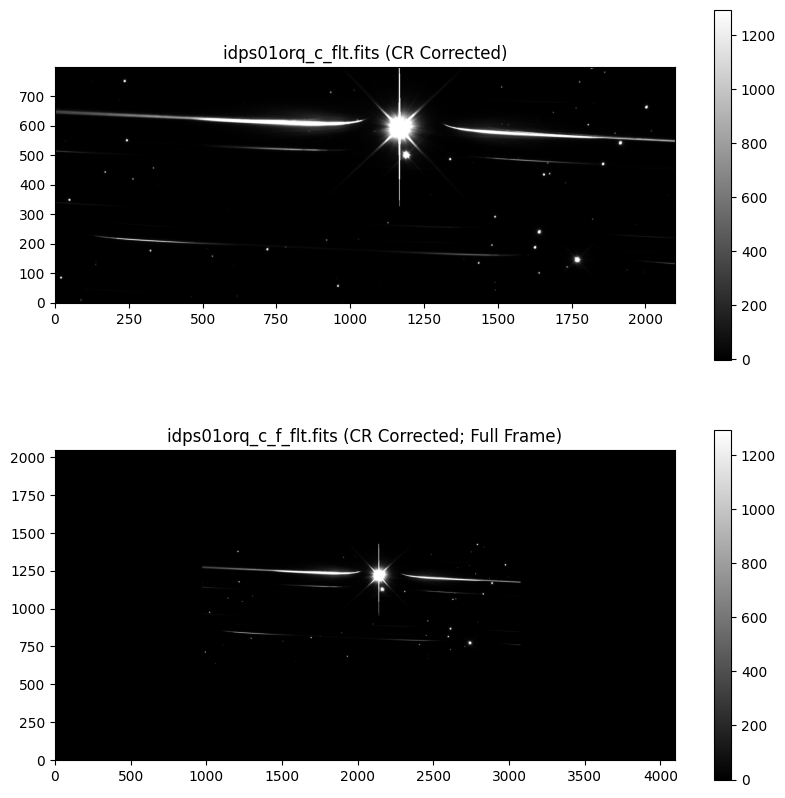

In [31]:
fig, axs = plt.subplots(2, 1, figsize=[10, 10])

# Plot clean grism image
axs[0].set_title(f'{file_grism_image_c} (CR Corrected)')
axs0 = axs[0].imshow(grism_image_c, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
cbar = fig.colorbar(axs0, ax=axs[0])

# Plot clean full frame grism image
axs[1].set_title(f'{file_grism_image_c_f} (CR Corrected; Full Frame)')
axs1 = axs[1].imshow(grism_image_c_f, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
cbar = fig.colorbar(axs1, ax=axs[1])

## 6. Spectral Trace Fitting
<a id="trace_fitting"></a>

We fit the spectral trace using `g280_transit_tools.fit_spectral_trace`. This function uses [GRISMCONF](https://github.com/npirzkal/GRISMCONF/tree/master), which implements the grism configuration detailed in [Pirzkal & Ryan (2017)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-01.pdf). We download the [configuration files](https://github.com/npirzkal/GRISM_WFC3/blob/master) required to fit the spectral trace.

In [32]:
!git clone https://github.com/npirzkal/GRISM_WFC3.git

fatal: destination path 'GRISM_WFC3' already exists and is not an empty directory.


First, we extract the +1 and -1 orders of one of the cleaned full frame images for the full width of G280 (0.2-0.8 $\mu$m).

In [33]:
# Define parameters
path_config = 'GRISM_WFC3/UVIS/UVIS_G280_CCD2_V2.conf'
order_p1 = '+1'
order_m1 = '-1'
wl_min = 2000
wl_max = 8000

# Fit +1 spectral trace
trace_x_p1, trace_y_p1, wavelength_p1, sensitivity_p1 = g280_transit_tools.fit_spectral_trace(
    path_config, source_x, source_y, order_p1, wl_min, wl_max
)

# Fit -1 spectral trace
trace_x_m1, trace_y_m1, wavelength_m1, sensitivity_m1 = g280_transit_tools.fit_spectral_trace(
    path_config, source_x, source_y, order_m1, wl_min, wl_max
)

We plot the sensitivity profiles of each order normalized by the +1 maximum sensitivity.

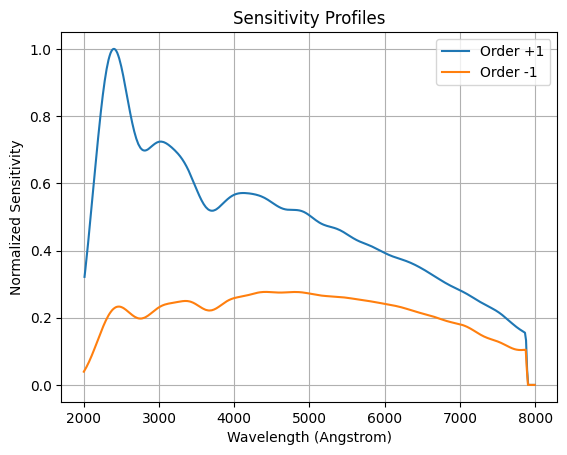

In [34]:
plt.grid()
plt.title('Sensitivity Profiles')
plt.plot(wavelength_p1, sensitivity_p1/sensitivity_p1.max(), label=f'Order {order_p1}')
plt.plot(wavelength_m1, sensitivity_m1/sensitivity_p1.max(), label=f'Order {order_m1} ')
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Normalized Sensitivity')
plt.legend()

The +1 order has a higher sensitivity than -1 order. Next, we normalize the exposure.

In [35]:
exptime = fits.getval(path_grism_image_c_f, 'exptime')
spec_data = grism_image_c_f / exptime

Now, we plot the spectral traces using an aperture of +/- 30 pixels outside of the y trace.

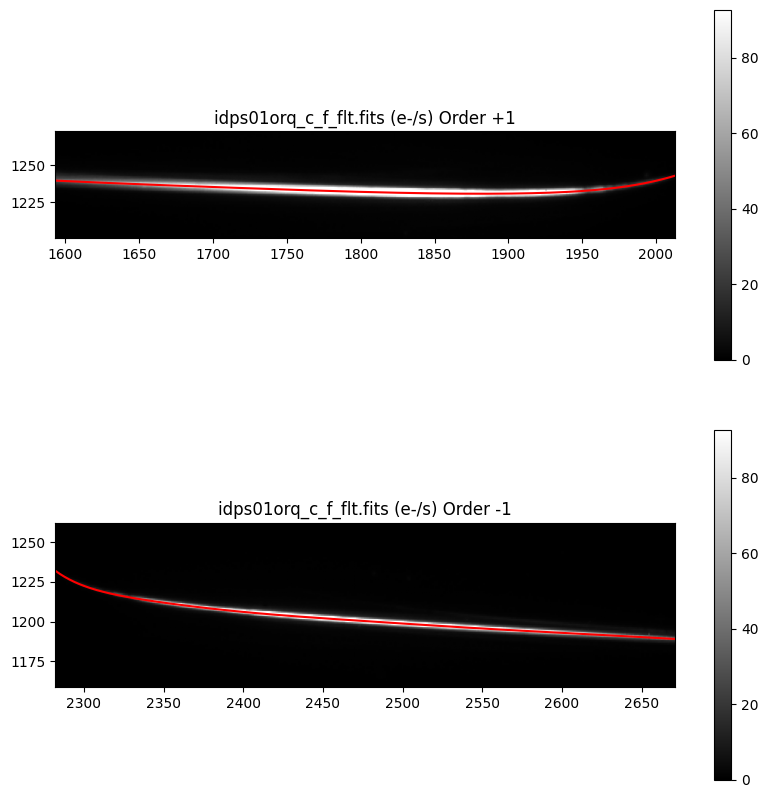

In [36]:
# Define aperture windows
n = 30
aperture_min_p1 = trace_y_p1.min() - n
aperture_max_p1 = trace_y_p1.max() + n
aperture_min_m1 = trace_y_m1.min() - n
aperture_max_m1 = trace_y_m1.max() + n

vmin, vmax = np.percentile(spec_data, (1, 99.95))
fig, axs = plt.subplots(2, 1, figsize=[10, 10])

# Plot +1 order
axs[0].set_title(f'{file_grism_image_c_f} (e-/s) Order {order_p1}')
axs0 = axs[0].imshow(spec_data, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
axs[0].plot(trace_x_p1, trace_y_p1, color='r')
axs[0].set_xlim(np.min(trace_x_p1), np.max(trace_x_p1))
axs[0].set_ylim(aperture_min_p1, aperture_max_p1)
cbar = fig.colorbar(axs0, ax=axs[0])

# Plot -1 order
axs[1].set_title(f'{file_grism_image_c_f} (e-/s) Order {order_m1}')
axs1 = axs[1].imshow(spec_data, vmin=vmin, vmax=vmax, origin='lower', cmap='gray')
axs[1].plot(trace_x_m1, trace_y_m1, color='r')
axs[1].set_xlim(np.min(trace_x_m1), np.max(trace_x_m1))
axs[1].set_ylim(aperture_min_m1, aperture_max_m1)
cbar = fig.colorbar(axs1, ax=axs[1])

## 7. G280 Spectral Extraction
<a id="extraction"></a>  

With our fitted spectral traces, we extract the 1D stellar spectra within a given aperture window using `g280_transit_tools.extract_spectrum`. In the example below, we use an aperture window that matches the y-axis scale in the plot above. The exact size of this aperture window is a parameter that we can refine and optimize later on in our analysis.

In [37]:
# Extract +1 order spectrum
counts_p1, counts_err_p1 = g280_transit_tools.extract_spectrum(
    path_grism_image_c_f, aperture_min_p1, aperture_max_p1, trace_x_p1
)

# Extract -1 order spectrum
counts_m1, counts_err_m1 = g280_transit_tools.extract_spectrum(
    path_grism_image_c_f, aperture_min_m1, aperture_max_m1, trace_x_m1
)

We plot our 1D spectra for the +1 and -1 orders.

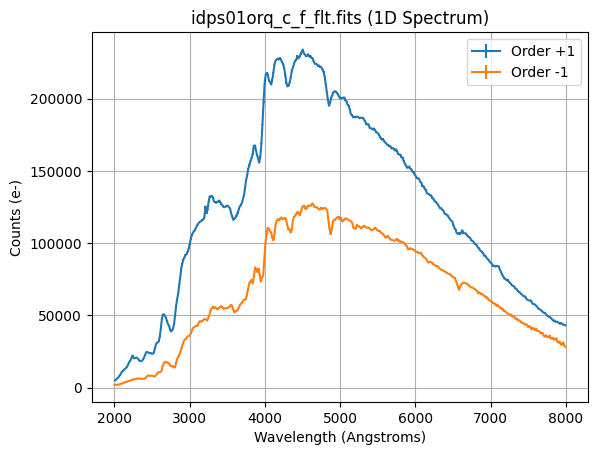

In [38]:
plt.grid()
plt.title(f'{file_grism_image_c_f} (1D Spectrum)')
plt.errorbar(wavelength_p1, counts_p1, counts_err_p1, label=f'Order {order_p1}')
plt.errorbar(wavelength_m1, counts_m1, counts_err_m1, label=f'Order {order_m1}')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Counts (e-)')
plt.legend()

The +1 order has a factor of ~2 higher throughput compared to the -1 order. 

## 8. Extracting 1D Time-Series Stellar Spectra
<a id="spectra"></a>  

Using the spectral trace fitting parameters, we perform spectral extraction for all of the full frame images in the time series using the previous values for `aperture_min` and `aperture_max` for `g280_transit_tools.extract_spectrum`.

In [39]:
# Retrieve clean embeded flt paths
paths_c_f_flt = sorted(glob.glob(f'{flt_full_dir}/*'))

# Initialize arrays 
time_series_counts_p1 = np.zeros((n_spectra, len(trace_x_p1)))
time_series_counts_err_p1 = np.zeros((n_spectra, len(trace_x_p1)))
time_series_counts_m1 = np.zeros((n_spectra, len(trace_x_m1)))
time_series_counts_err_m1 = np.zeros((n_spectra, len(trace_x_m1)))

# Loop over all exposures 
for i, path_c_f in tqdm.tqdm(enumerate(paths_c_f_flt), total=n_spectra):

    # Extract 1D spectra +1 order
    counts_p1, counts_err_p1 = g280_transit_tools.extract_spectrum(
        path_c_f, aperture_min_p1, aperture_max_p1, trace_x_p1
    )

    # Extract 1D spectra -1 order
    counts_m1, counts_err_m1 = g280_transit_tools.extract_spectrum(
        path_c_f, aperture_min_m1, aperture_max_m1, trace_x_m1
    )

    # Record data
    time_series_counts_p1[i] = counts_p1
    time_series_counts_err_p1[i] = counts_err_p1
    time_series_counts_m1[i] = counts_m1
    time_series_counts_err_m1[i] = counts_err_m1

  0%|          | 0/54 [00:00<?, ?it/s]

 19%|█▊        | 10/54 [00:00<00:00, 98.52it/s]

 39%|███▉      | 21/54 [00:00<00:00, 100.07it/s]

 59%|█████▉    | 32/54 [00:00<00:00, 99.92it/s] 

 80%|███████▉  | 43/54 [00:00<00:00, 100.04it/s]

100%|██████████| 54/54 [00:00<00:00, 99.89it/s] 

100%|██████████| 54/54 [00:00<00:00, 99.72it/s]

We also extract the midexposure times and hours from mid-transit of the observations.

In [40]:
mjd = np.median([(fits.getval(path, 'expstart'), fits.getval(path, 'expend')) for path in paths_flt], axis=1)
hours = (mjd - mjd.mean()) * 24

Now, we plot the time-series of 1D stellar spectra colored by hours from mid-transit, and the median spectrum colored in black.

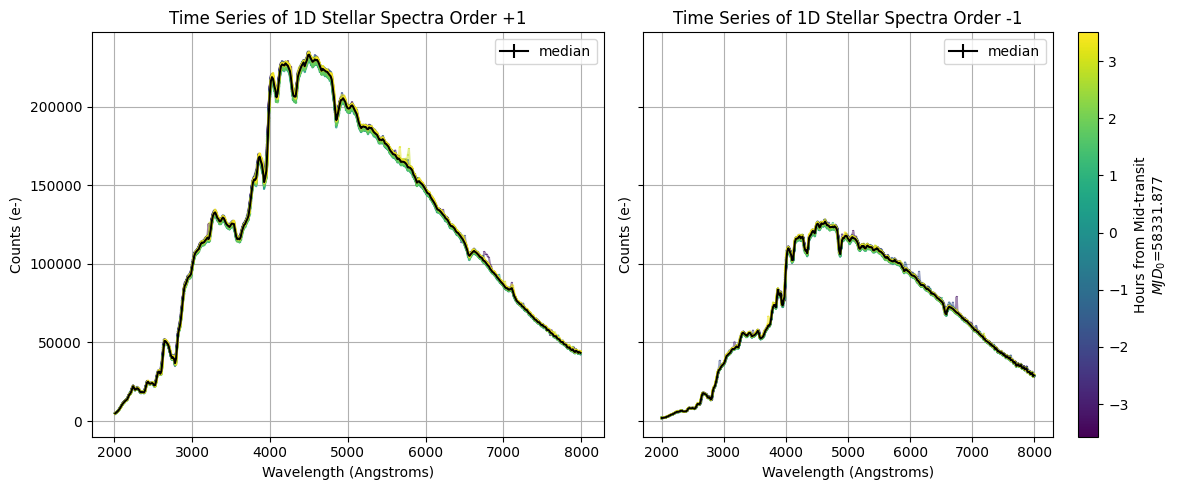

In [41]:
# Configure colorbar scale
cmap = cm.viridis
norm = plt.Normalize(hours.min(), hours.max())
colors = cmap(norm(hours))

# Plot spectra +1 order and median
fig, axs = plt.subplots(1, 2, figsize=[12, 5], sharey=True)
axs[0].grid()
axs[0].set_title(f'Time Series of 1D Stellar Spectra Order {order_p1}')
for i, (counts, counts_err) in enumerate(zip(time_series_counts_p1, time_series_counts_err_p1)):
    axs0 = axs[0].errorbar(wavelength_p1, counts, counts_err, alpha=0.5, color=colors[i])
counts_median_p1 = np.median(time_series_counts_p1, axis=0)
counts_err_median_p1 = np.median(time_series_counts_err_p1, axis=0)
axs[0].errorbar(wavelength_p1, counts_median_p1, counts_err_median_p1, color='k', label='median')
axs[0].set_xlabel('Wavelength (Angstroms)')
axs[0].set_ylabel('Counts (e-)')
axs[0].legend()

# Plot spectra -1 order and median
axs[1].grid()
axs[1].set_title(f'Time Series of 1D Stellar Spectra Order {order_m1}')
for i, (counts, counts_err) in enumerate(zip(time_series_counts_m1, time_series_counts_err_m1)):
    axs1 = axs[1].errorbar(wavelength_m1, counts, counts_err, alpha=0.5, color=colors[i])
counts_median_m1 = np.median(time_series_counts_m1, axis=0)
counts_err_median_m1 = np.median(time_series_counts_err_m1, axis=0)
axs[1].errorbar(wavelength_m1, counts_median_m1, counts_err_median_m1, color='k', label='median')
axs[1].set_xlabel('Wavelength (Angstroms)')
axs[1].set_ylabel('Counts (e-)')
axs[1].legend()

# Set colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs[1])
cbar.set_label(f'Hours from Mid-transit\n$MJD_0$={mjd.min():.3f}')
fig.tight_layout()

## 9. Generating Light Curves
<a id="lc"></a>  

With 1D time series stellar spectra, we generate the broadband (i.e. white light) light curves, which is extracted across the full wavelength range of the G280 grism. We generate the light curve using `g280_transit_tools.make_light_curve`.

In [42]:
# +1 order
lc_counts_p1, lc_counts_err_p1 = g280_transit_tools.make_light_curve(
    wavelength_p1, time_series_counts_p1, wl_min=wl_min, wl_max=wl_max
)

# -1 order
lc_counts_m1, lc_counts_err_m1 = g280_transit_tools.make_light_curve(
    wavelength_m1, time_series_counts_m1, wl_min=wl_min, wl_max=wl_max
)

Finally, we plot the normalized light curves.

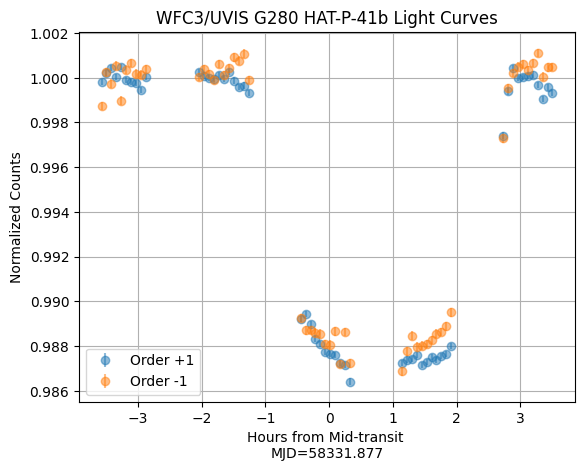

In [43]:
# Normalize counts by mean of first 10 measurements
lc_counts_p1_norm = lc_counts_p1 / np.mean(lc_counts_p1[0:10])
lc_counts_m1_norm = lc_counts_m1 / np.mean(lc_counts_m1[0:10])

plt.grid()
plt.title('WFC3/UVIS G280 HAT-P-41b Light Curves')
plt.errorbar(hours, lc_counts_p1_norm, lc_counts_err_p1, ls='', marker='o', label=f'Order {order_p1}', alpha=0.5)
plt.errorbar(hours, lc_counts_m1_norm, lc_counts_err_m1, ls='', marker='o', label=f'Order {order_m1}', alpha=0.5)
plt.xlabel(f'Hours from Mid-transit \nMJD={mjd.min():.3f}')
plt.ylabel('Normalized Counts')
plt.legend()

The raw white light curves for the +1 and -1 orders look great! We can also use the above function to generate the spectroscopic light curves by changing the `wl_min` and `wl_max` values. 

## 10. Conclusions
<a id="summary"></a>  

Thank you for walking through this notebook. With G280 transit observations, you should now be familiar with:

- Downloading data from MAST.
- Performing cosmic ray correction and background subtraction for the time-series.
- Performing trace fitting and spectral extraction for G280 data.
- Generating white light curves.

You can now assemble the G280 transmission spectrum for any exoplanet and for any of the spectral orders. Once you have extracted the white light and spectroscopic light curves, you can use various light curve fitting programs (e.g. [PACMAN](https://pacmandocs.readthedocs.io/en/latest/index.html), [WFC3 Light Curve Fitting](https://github.com/kevin218/WFC3), [Eureka!](https://eurekadocs.readthedocs.io/en/latest/index.html), etc.) to measure the transit depths.

**Congratulations, you have completed this tutorial for G280 exoplanet transit data!** 

## Additional Resources
<a id="add"></a>

Below are some additional resources that may be helpful. Please send any questions through the [HST Help Desk](https://stsci.service-now.com/hst).

- [WFC3 Website](https://www.stsci.edu/hst/instrumentation/wfc3)
    - [WFC3 Grism Resources](https://www.stsci.edu/hst/instrumentation/wfc3/documentation/grism-resources)
    - [G280 Calibration & Reference Files](https://www.stsci.edu/hst/instrumentation/wfc3/documentation/grism-resources/wfc3-g280-calibrations)
- [WFC3 Instrument Handbook](https://hst-docs.stsci.edu/wfc3ihb)
    - [Chapter 8: Slitless Spectroscopy with WFC3](https://hst-docs.stsci.edu/wfc3ihb/chapter-8-slitless-spectroscopy-with-wfc3)
- [WFC3 Data Handbook](https://hst-docs.stsci.edu/wfc3dhb)
    - [Chapter 9.3: Spectroscopy](https://hst-docs.stsci.edu/wfc3dhb/chapter-9-wfc3-data-analysis/9-3-spectroscopy)
- Papers
    - [Into the UV: A precise transmission spectrum of HAT-P-41b using Hubble's WFC3/UVIS G280 grism (Wakeford et al. 2020)](https://arxiv.org/abs/2003.00536)
    - [UV Absorption by Silicate Cloud Precursors in Ultra-hot Jupiter WASP-178b (Lothringer et al. 2022)](https://arxiv.org/abs/2204.03639)
    - [The HUSTLE Program: The UV to Near-Infrared HST WFC3/UVIS G280 Transmission Spectrum of WASP-127b(Boehm et al. 2024)](https://arxiv.org/abs/2410.17368)
- [WFC3 ISR 2023-06: The WFC3/UVIS G280 Grism Sky (Pagul et al. 2023)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2023/WFC3-ISR-2023-06.pdf)
- [GRISMCONF](https://github.com/npirzkal/GRISMCONF/tree/master)
    - [WFC3 ISR 2017-01: A more generalized coordinate transformation approach for grisms (Pirzkal and Ryan 2017)](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-01.pdf)
    - [GRISM_WFC3: Configuration files](https://github.com/npirzkal/GRISM_WFC3/tree/master)


## About this Notebook
<a id="about"></a>

**Author:** Munazza K. Alam, WFC3 & NIRSpec Instrument Teams

**Created On:** 2025-02-28

**Updated On:** 2025-03-25; Fred Dauphin, WFC3 Team

## Citations
<a id="cite"></a>
If you use the following packages for published research, please cite the authors. The links below contain for more information about citing the following:

* [Citing `numpy`](https://numpy.org/citing-numpy/)
* [Citing `matplotlib`](https://matplotlib.org/stable/project/citing.html)
* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `astroquery`](https://github.com/astropy/astroquery/blob/main/astroquery/CITATION)
* [Citing `photutils`](https://photutils.readthedocs.io/en/latest/getting_started/citation.html)
* [Citing `grismconf`](https://www.stsci.edu/files/live/sites/www/files/home/hst/instrumentation/wfc3/documentation/instrument-science-reports-isrs/_documents/2017/WFC3-2017-01.pdf)
<hr>

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/hst_notebooks/main/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 